<a href="https://colab.research.google.com/github/luismartins26/segcomp/blob/main/Trabalho_Pr%C3%A1tico_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático 01

CIC0201 - Segurança Computacional – 2025/1

Disciplina: Segurança Computacional

Professora: Lorena Borges

Estudante: Luís Martins (242037814)

# Introdução

O trabalho está disponível em https://colab.research.google.com/drive/198A1oyLfz-MXqa149wFRMlNZrSqWfhYv?usp=sharing e https://github.com/luismartins26/segcomp/blob/main/Trabalho_Pr%C3%A1tico_TP1.ipynb

O objetivo desse caderno é elaborar o código para encriptação e decriptação do algoritmo Simplified Data Encryption Standard (SDES), atentando para os fins educacionais desse algoritmo, sobretudo no que concerne descritivo do SDES e da
resolução em etapas das funções intermediárias para o texto em claro e chaves fornecidas, bem como implementação dos modos de operação de cifra de blocos ECB (Electronic Codebook) e CBC (Cipher Block Chaining) sobre o SDES. O trabalho está dividido em duas partes, na primeira, o SDES é implementado e testado com chave e mensagem informadas. Já, na segunda, os modos de operação são implementados e testados com os dados informados.

Este trabalho contou com o auxílio de ferramentas de Inteligência Artificial (OPENAI, 2023; GOOGLE, 2024) para a geração de funções auxiliares e revisão do texto escrito. Todo o conteúdo gerado foi cuidadosamente revisado, ajustado e validado, garantindo a sua adequação, coerência e conformidade com os objetivos do trabalho.

# Definições

## Inicialização de bibliotecas e classe base

In [124]:
from abc import ABC, abstractmethod
import math
from collections import OrderedDict
import random

Para auxiliar a verificação de etapas intermediárias, configura-se um logger para registrar as alterações que a mensagem ou chave passam por cada parte do algoritmo.

In [125]:
# prompt: configure logger and log a sample message

import logging

# Configure the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create a handler to write log messages to a file (optional)
file_handler = logging.FileHandler('sdes.log')  # Creates or overwrites the file
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Parte I

Aproveitando o arcabouço construído na Lista de Exercícios 1, pode-se conceber o SDES como uma subclasse de uma cifra genérica, seguindo a definição passada em aula.

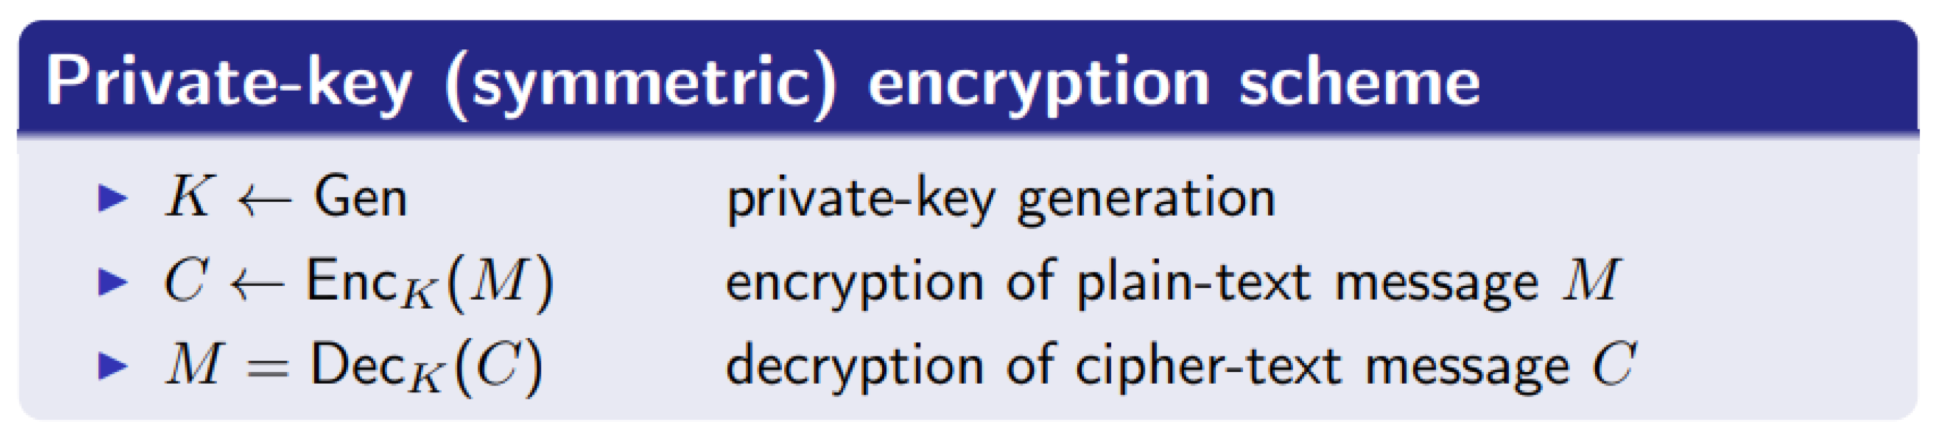

In [126]:
class Cifra(ABC):
    @abstractmethod
    def Gen(self) -> any:
        pass

    def set_key(self, key):
        self.key = key

    @abstractmethod
    def Enc(self, M: str) -> str:
        pass

    @abstractmethod
    def Dec(self, C: str) -> str:
        pass

Por sua vez, o SDES pode ser abstraído como um conjunto de módulos, que têm como entrada e saída determinada sequência de bits. A classe abstrata Modulo representa esse comportamento.

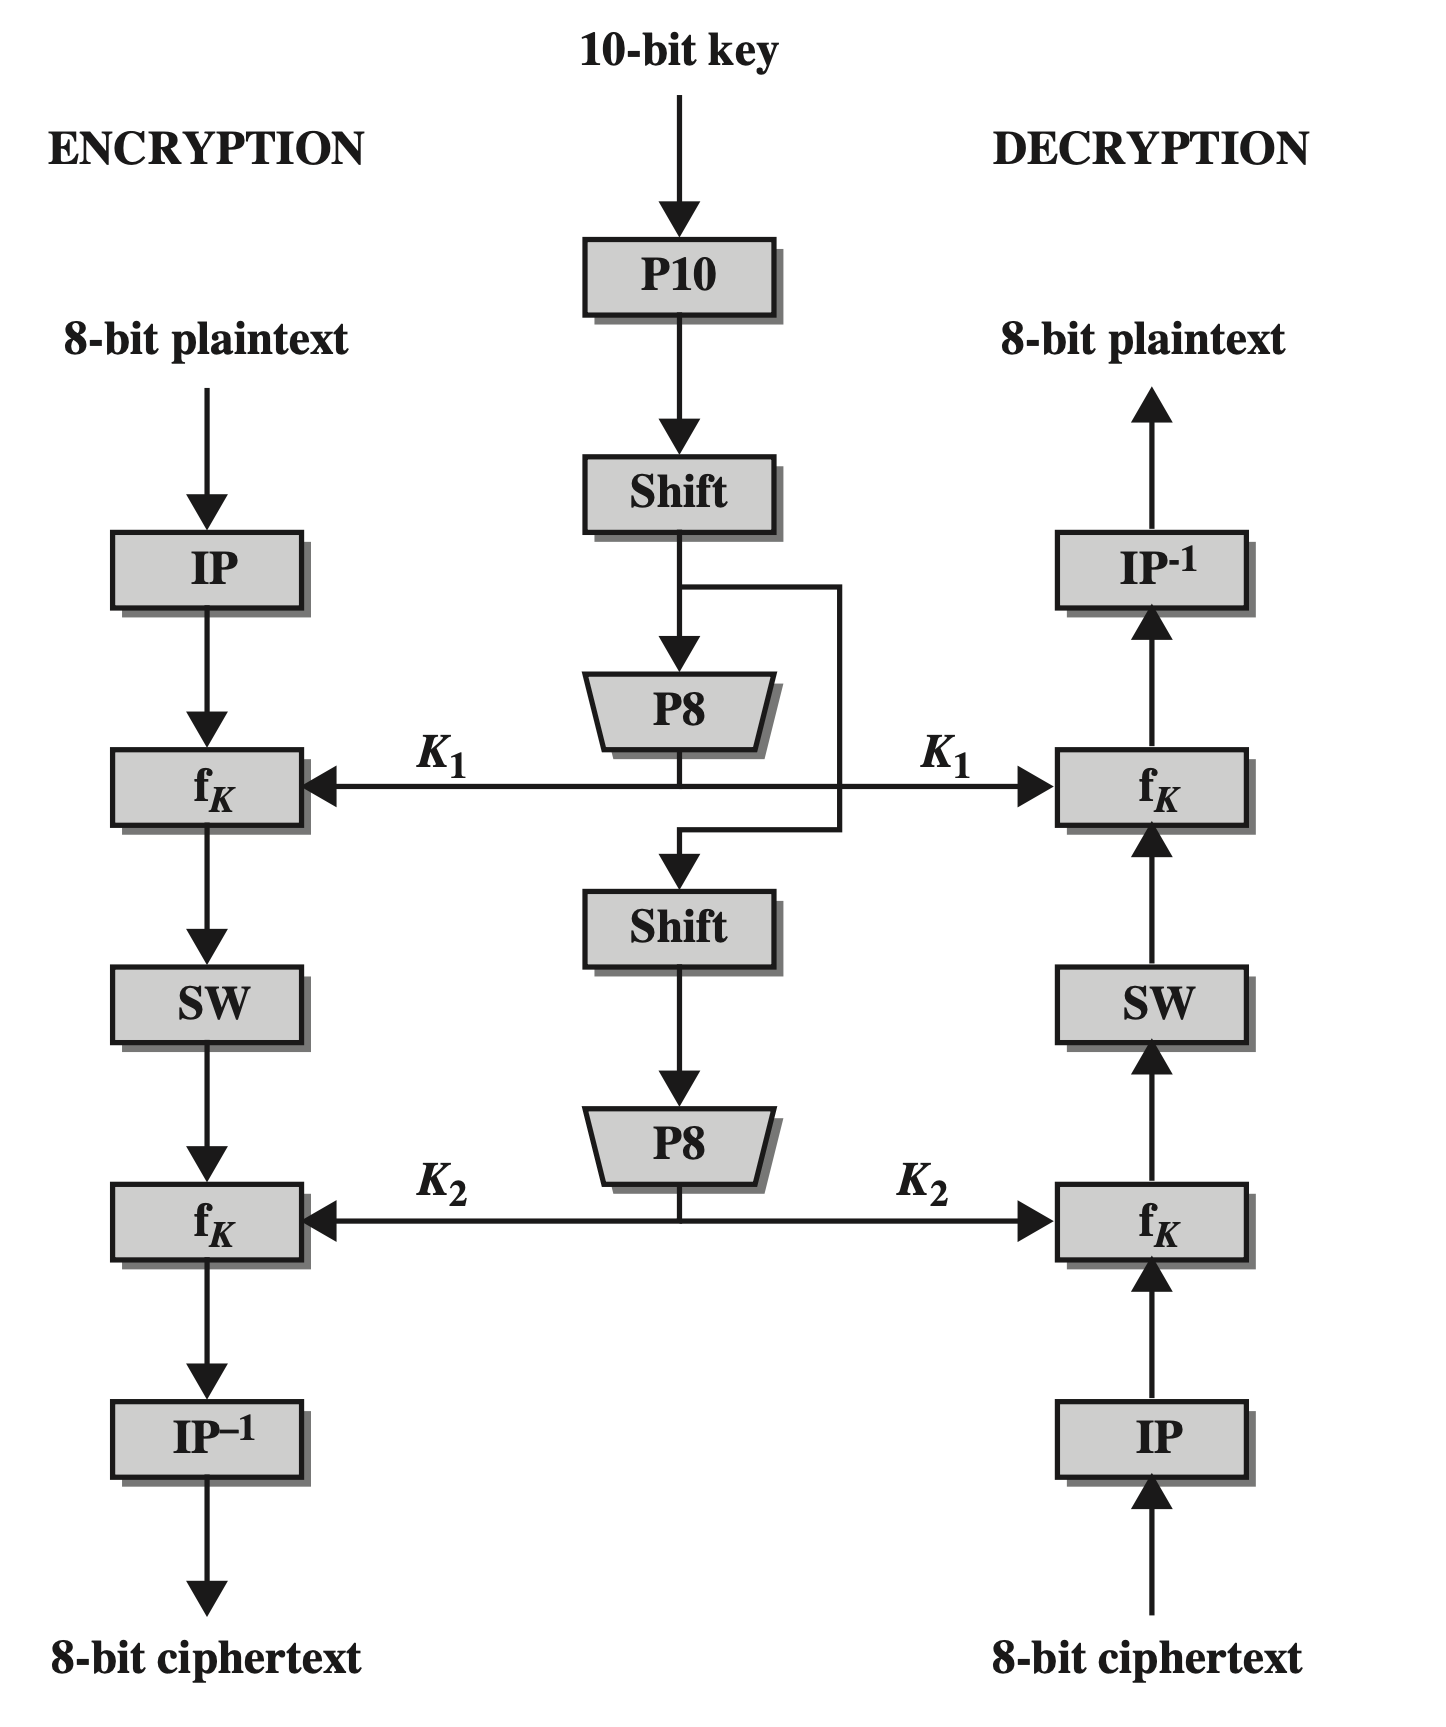

In [127]:
class Modulo(ABC):
    def __init__(self, chave):
        self.key = chave

    @abstractmethod
    def executar(self, T : str) -> str:
        pass

Do diagrama, observa-se que há basicamente três tipos (subclasses) de módulos, permutador, caixa de substituição e o que foi chamado de selecionador. Todos esses módulos recebem um parâmetro *key*, que determina como a sequência de bits de entrada deve ser tratado.

A notação de uma linha representa uma permutação listando diretamente a imagem de cada elemento na ordem.

Seja uma permutação $ \Pi $ do conjunto $ P = \{1, 2, \dots, n\} $, com $\pi:P→P$ bijetora, então:

$$
\Pi = \begin{pmatrix}
1 & 2 & \cdots & n \\
\pi(1) & \pi(2) & \cdots & \pi(n)
\end{pmatrix}
$$

Na notação de uma linha, escrevemos apenas a segunda linha, que representa a chave da permutação:

$$
\Pi' = [\pi(1)\ \pi(2)\ \cdots\ \pi(n)]
$$

Caso a permutação tenha comprimento diferente do da mensagem, no processo de encriptação, 0s são adicionados (*padding*) até que o comprimento da mensagem seja divisível pelo comprimento da chave. Se a chave tiver mesmo comprimento da mensagem estendida, a permutação é realizada. Se a chave tiver tamanho inferior, a mensagem é dividida em blocos do tamanho da chave, os blocos são permutados conforme a chave e unidos novamente, mantendo a ordem original em que foram divididos.

In [128]:
class Permutador(Modulo):
    def executar(self, T : str) -> str:
        # Cria a lista C preenchida com espaços para armazenar o texto cifrado
        C = ['0']*math.ceil(len(T)/len(self.key))*len(self.key)
        # Preenche a mensagem original com espaços extras
        T = T+'0'*(math.ceil(len(T)/len(self.key))*len(self.key)-len(T))
        # Para cada bloco de tamanho igual ao da chave
        for j in range(math.ceil(len(T)/len(self.key))):
            # Aplica a permutação no bloco
            for i, k in enumerate(self.key):
                C[j*len(self.key)+i] = T[j*len(self.key)+k]
        # Junta a lista de caracteres em uma string e retorna o texto cifrado
        return "".join(C)

À exceção do padding, a permutação preserva o tamanho da sequência de bits de entrada. Por sua vez, o selecionador pode ser entendido como uma operação que recebe como *key* uma sequência de elementos de $P$, indicando como a sequência de bits de saída é montado, a partir da posição de origem dos bits de entrada. Não há garantia que o comprimento de entrada seja o mesmo do que o de saída, portanto pode representar uma truncagem ou expansão dos dados originais.

In [129]:
class Selecionador(Modulo):
    def executar(self, T : str) -> str:
        # Cria lista a ser preenchida
        T_ = []
        # Para cada elemento na key
        for i in self.key:
            # Adiciona elemento correspondente à posição da key
            T_.append(T[i])
        # Retorna lista preenchida
        return "".join(T_)

A caixa de substituição se diferencia do permutador e selecionador por seu parâmetro não ser uma sequência numérica, mas sim uma matriz de valores. Recebe como entrada uma sequência de 4 bits, que é dividida em duas partes, correspondentes ao número da linha e coluna da matriz. O elemento presente nessa interseção é a saída da caixa.

In [130]:
# Transforma sequência de bits de string para int correspondente
def binario_para_numerico(T : str) -> int:
    return int(T, 2)

# Transforma int para string de bits, pode ser necessário usar padding para manter o tamanho original da sequência de bits
def numerico_para_binario(n: int) -> str:
    return bin(n)[2:]

In [131]:
class CaixaSubstituicao(Modulo):
    def executar(self, T : str) -> str:
        # Para acessar o elemento da matriz, é necessário transformar sequência de bits para valos numérico
        p1 = binario_para_numerico(T[0]+T[3])
        p2 = binario_para_numerico(T[1]+T[2])
        r = self.key[p1][p2]
        # Padding (zfill) é necessário para garantir saída de sequência binária de comprimento 2
        return numerico_para_binario(r).zfill(2)

O diagrama anterior simplificou a rodada de Feistel ($f_K$) a um único módulo, porém se percebe que, ao detalhar sua composição, é composta também daqueles três tipos de módulos.

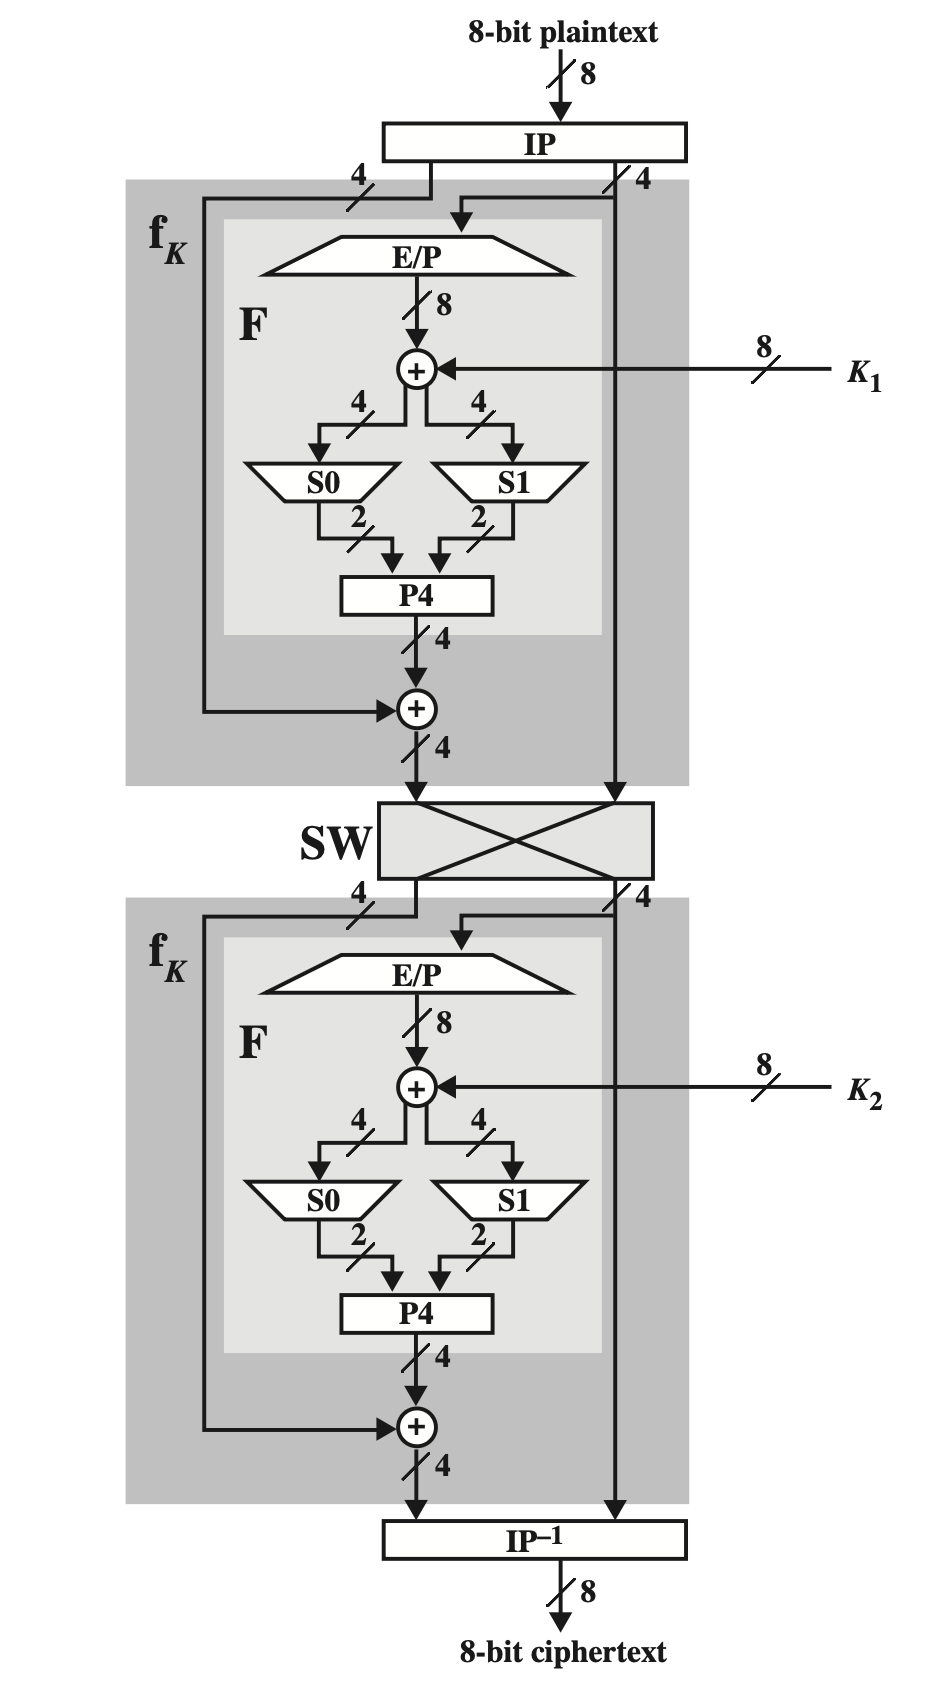

In [132]:
# Funcão para auxiliar operação de XOR
def xor(s1: str, s2: str) -> str:
    return numerico_para_binario(binario_para_numerico(s1) ^ binario_para_numerico(s2)).zfill(len(s1))

In [133]:
class RodadaFeistel(Modulo):
    def __init__(self):
        self.modulos = OrderedDict()

    def set_EP_key(self, key):
        self.EP_key = key

    def set_S1_key(self, key):
        self.S1_key = key

    def set_S2_key(self, key):
        self.S2_key = key

    def set_P4_key(self, key):
        self.P4_key = key

    def set_subkey(self, subkey):
        self.subkey = subkey

    def executar(self, T : str) -> str:
        logger.info(f'\tRodada Feistel de {T} com subchave {self.subkey}')

        if self.modulos == OrderedDict():
            self.fabricar_modulos()

        L = T[:4]
        R = T[4:]
        T = self.modulos['EP'].executar(R)
        logger.info(f'\t\tApós a realização da operação EP, a sequência resultante é {T}')
        T = xor(T, self.subkey)
        logger.info(f'\t\tApós a realização da operação XOR, a sequência resultante é {T}')
        T1 = self.modulos['S1'].executar(T[:4])
        logger.info(f'\t\tApós a realização da operação S1, a sequência resultante é {T1}')
        T2 = self.modulos['S2'].executar(T[4:])
        logger.info(f'\t\tApós a realização da operação S2, a sequência resultante é {T2}')
        T = T1+T2
        logger.info(f'\t\tApós a realização das operações S1 e S2, a sequência resultante é {T}')
        T = self.modulos['P4'].executar(T)
        logger.info(f'\t\tApós a realização da operação P4, a sequência resultante é {T}')
        T = xor(L, T)
        logger.info(f'\t\tApós a realização da operação XOR, a sequência resultante é {T}')
        resultado = T+R
        logger.info(f'\tO resultado da rodada Feistel é {resultado}')
        return resultado

    def fabricar_modulos(self):
        self.modulos['EP'] = Permutador(self.EP_key)
        self.modulos['S1'] = CaixaSubstituicao(self.S1_key)
        self.modulos['S2'] = CaixaSubstituicao(self.S2_key)
        self.modulos['P4'] = Permutador(self.P4_key)


Definidas as classes de módulos, criou-se uma classe para facilitar sua criação, sobretudo a rodada de Feistel, que possui uma estrutura pré-definida para as *keys* de seus módulos.

In [134]:
class FabricaModulo():
    def fabricar_permutador(self, chave) -> Permutador:
        p = Permutador(chave)
        return p

    def fabricar_selecionador(self, chave) -> Selecionador:
        p = Selecionador(chave)
        return p

    def fabricar_caixa_substituicao(self, chave) -> CaixaSubstituicao:
        p = CaixaSubstituicao(chave)
        return p

    def fabricar_rodada_feistel(self) -> RodadaFeistel:
        p = RodadaFeistel()
        p.set_EP_key([3, 0, 1, 2, 1, 2, 3, 0])
        p.set_S1_key([[1, 0, 3, 2], [3, 2, 1, 0], [0, 2, 1, 3], [3, 1, 3, 2]])
        p.set_S2_key([[0, 1, 2, 3], [2, 0, 1, 3], [3, 0, 1, 0], [2, 1, 0, 3]])
        p.set_P4_key([1, 3, 2, 0])

        return p

A classe que implementa a cifra SDES é dividida na geração das subchaves e encriptação propriamente dita. Em ambos os casos, a fábrica cria os módulos, que são organizados em dicionários.

In [135]:
class SDES(Cifra):
    def criar_gerador_subchaves(self):
        self.gerador_subchaves = OrderedDict()
        P10 = self.fabrica.fabricar_permutador([2, 4, 1, 6, 3, 9, 0, 8, 7, 5])
        self.gerador_subchaves['P10'] = P10
        S1 = self.fabrica.fabricar_permutador([1, 2, 3, 4, 0])
        self.gerador_subchaves['S1'] = S1
        P8 = self.fabrica.fabricar_selecionador([5, 2, 6, 3, 7, 4, 9, 8])
        self.gerador_subchaves['P8'] = P8
        S2 = self.fabrica.fabricar_permutador([2, 3, 4, 0, 1])
        self.gerador_subchaves['S2'] = S2

    def __init__(self):
        self.fabrica = FabricaModulo()
        self.criar_gerador_subchaves()
        self.criar_encriptador()

    def set_key(self, key):
        self.key = key
        self.gerar_subchaves(key)
        self.encriptador['F1'].set_subkey(self.subchaves['K1'])
        self.encriptador['F2'].set_subkey(self.subchaves['K2'])

    def criar_encriptador(self):
        self.encriptador = OrderedDict()
        IP = self.fabrica.fabricar_permutador([1, 5, 2, 0, 3, 7, 4, 6])
        self.encriptador['IP'] = IP
        F1 = self.fabrica.fabricar_rodada_feistel()
        self.encriptador['F1'] = F1
        SW = self.fabrica.fabricar_permutador([4, 5, 6, 7, 0, 1, 2, 3])
        self.encriptador['SW'] = SW
        F2 = self.fabrica.fabricar_rodada_feistel()
        self.encriptador['F2'] = F2
        IP_1 = self.fabrica.fabricar_permutador([3, 0, 2, 4, 6, 1, 7, 5])
        self.encriptador['IP_1'] = IP_1

    def Gen(self) -> str:
        # Gera número de 10 bits aleatoriamente
        k = random.getrandbits(10)
        k = numerico_para_binario(k)
        # Para garantir que a chave tenha comprimento 10, pode ser necessário realizar padding
        k = k.zfill(10)
        return k

    def gerar_subchaves(self, K : str) -> OrderedDict:
        logger.info(f'Gerando subchaves a partir da chave {K}')
        self.subchaves = OrderedDict()
        T = self.gerador_subchaves['P10'].executar(K)
        logger.info(f'\tApós a realização da operação P10, a sequência resultante é {T}')
        T = self.gerador_subchaves['S1'].executar(T)
        logger.info(f'\tApós a realização da operação S1, a sequência resultante é {T}')
        self.subchaves['K1'] = self.gerador_subchaves['P8'].executar(T)
        logger.info(f'\tApós a realização da operação P8, a subchave K1 resultante é {self.subchaves["K1"]}')
        T = self.gerador_subchaves['S2'].executar(T)
        logger.info(f'\tApós a realização da operação S2, a sequência resultante é {T}')
        self.subchaves['K2'] = self.gerador_subchaves['P8'].executar(T)
        logger.info(f'\tApós a realização da operação P8, a subchave K2 resultante é {self.subchaves["K2"]}')
        logger.info(f'As subchaves geradas são {self.subchaves}')

    def Enc(self, M: str) -> str:
        logger.info(f'Encriptando a mensagem {M}')
        T = self.encriptador['IP'].executar(M)
        logger.info(f'\tApós a realização da operação IP, a sequência resultante é {T}')
        T = self.encriptador['F1'].executar(T)
        logger.info(f'\tApós a realização da operação F1, a sequência resultante é {T}')
        T = self.encriptador['SW'].executar(T)
        logger.info(f'\tApós a realização da operação SW, a sequência resultante é {T}')
        T = self.encriptador['F2'].executar(T)
        logger.info(f'\tApós a realização da operação F2, a sequência resultante é {T}')
        C = self.encriptador['IP_1'].executar(T)
        logger.info(f'\tApós a realização da operação IP_1, a sequência resultante é {C}')
        logger.info(f'A mensagem criptografada é {C}')
        return C

    def Dec(self, C: str) -> str:
        logger.info(f'Decriptando a mensagem {C}')
        T = self.encriptador['IP'].executar(C)
        logger.info(f'\tApós a realização da operação IP, a sequência resultante é {T}')
        T = self.encriptador['F2'].executar(T)
        logger.info(f'\tApós a realização da operação F2, a sequência resultante é {T}')
        T = self.encriptador['SW'].executar(T)
        logger.info(f'\tApós a realização da operação SW, a sequência resultante é {T}')
        T = self.encriptador['F1'].executar(T)
        logger.info(f'\tApós a realização da operação F1, a sequência resultante é {T}')
        M = self.encriptador['IP_1'].executar(T)
        logger.info(f'\tApós a realização da operação IP_1, a sequência resultante é {M}')
        logger.info(f'A mensagem decriptografada é {M}')
        return M


In [136]:
logger.info('------------------------------------------')
logger.info('Execução do algoritmo SDES')
sdes = SDES()
sdes.set_key('1010000010')
M = '11010111'
logger.info('')
C = sdes.Enc(M)
logger.info('')
M_ = sdes.Dec(C)
assert M == M_
logger.info('------------------------------------------')

INFO:root:------------------------------------------
INFO:root:Execução do algoritmo SDES
INFO:root:Gerando subchaves a partir da chave 1010000010
INFO:root:	Após a realização da operação P10, a sequência resultante é 1000001100
INFO:root:	Após a realização da operação S1, a sequência resultante é 0000111000
INFO:root:	Após a realização da operação P8, a subchave K1 resultante é 10100100
INFO:root:	Após a realização da operação S2, a sequência resultante é 0010000011
INFO:root:	Após a realização da operação P8, a subchave K2 resultante é 01000011
INFO:root:As subchaves geradas são OrderedDict([('K1', '10100100'), ('K2', '01000011')])
INFO:root:
INFO:root:Encriptando a mensagem 11010111
INFO:root:	Após a realização da operação IP, a sequência resultante é 11011101
INFO:root:	Rodada Feistel de 11011101 com subchave 10100100
INFO:root:		Após a realização da operação EP, a sequência resultante é 11101011
INFO:root:		Após a realização da operação XOR, a sequência resultante é 01001111
INFO:

In [137]:
print(f'As subchaves são {sdes.subchaves}')

As subchaves são OrderedDict([('K1', '10100100'), ('K2', '01000011')])


In [138]:
print(f'A mensagem criptografada é {C}')

A mensagem criptografada é 10101000


Como não foi fornecida mensagem criptografada para verificação de criptografia, compara-se encriptação com valores testados na implementação de Terenceli (2014).

In [139]:
logger.info('------------------------------------------')
logger.info('Teste extra da execução do algoritmo SDES')
sdes = SDES()
sdes.set_key('1100011110')
logger.info('')
M = '00101000'
C = sdes.Enc(M)
logger.info('')
assert C == '10001010'
M_ = sdes.Dec(C)
assert M == M_
logger.info('------------------------------------------')

INFO:root:------------------------------------------
INFO:root:Teste extra da execução do algoritmo SDES
INFO:root:Gerando subchaves a partir da chave 1100011110
INFO:root:	Após a realização da operação P10, a sequência resultante é 0011001111
INFO:root:	Após a realização da operação S1, a sequência resultante é 0110011110
INFO:root:	Após a realização da operação P8, a subchave K1 resultante é 11101001
INFO:root:	Após a realização da operação S2, a sequência resultante é 1000111011
INFO:root:	Após a realização da operação P8, a subchave K2 resultante é 10100111
INFO:root:As subchaves geradas são OrderedDict([('K1', '11101001'), ('K2', '10100111')])
INFO:root:
INFO:root:Encriptando a mensagem 00101000
INFO:root:	Após a realização da operação IP, a sequência resultante é 00100010
INFO:root:	Rodada Feistel de 00100010 com subchave 11101001
INFO:root:		Após a realização da operação EP, a sequência resultante é 00010100
INFO:root:		Após a realização da operação XOR, a sequência resultante é

# Parte II

A cifra de bloco estabelece como realizar a (des)criptografia de um único bloco, mas não como realizar a (des)criptografia de uma sequência de bits com comprimento superior ao tamanho de bloco. O modo de operação define como isso deve ser feito. Começa-se com a definição de uma classe abstrata, que define um modo de operação genérico. É necessário que haja funcionalidades de encriptação e decriptação, além de estabelecimento da cifra em si.

In [140]:
class ModoOperacao(ABC):
    @abstractmethod
    def encriptar(self, M: str) -> str:
        pass

    @abstractmethod
    def decriptar(self, C: str) -> str:
        pass

    def __init__(self, cifra: Cifra):
        self.cifra = cifra

O modo de operação ECB (Electronic Codebook) consiste na simples separação da mensagem em blocos do tamanho exato de entrada para a cifra e encriptação ou decriptação deles, com eventual *padding* para completar bloco final, caso o comprimento da mensagem não seja divisível pelo tamanho do bloco. Pode apresentar fragilidade se a mensagem for suficientemente grande, pois, como não há variabilidade de transformação dos blocos, blocos semelhantes de entrada resultam em blocos semelhantes de saída.

In [141]:
class ECB(ModoOperacao):
    def set_tamanho_bloco(self, tamanho_bloco):
        self.tamanho_bloco = tamanho_bloco

    def encriptar(self, M: str) -> str:
        logger.info(f'Encriptando mensagem {M}')
        # Inicializando a mensagem criptografada
        C = ''
        # Para cada bloco da mensagem
        for i in range(0, len(M), self.tamanho_bloco):
            logger.info(f'Encriptando bloco {M[i:i+self.tamanho_bloco]}')
            C_atual = self.cifra.Enc(M[i:i+self.tamanho_bloco])
            logger.info(f'Após a realização da encriptação, o bloco resultante é {C_atual}')
            # Concatena bloco atual com mensagem criptografada
            C += C_atual
            logger.info('----------------------------------------------')
        logger.info(f'A mensagem criptografada é: {C}')
        return C

    def decriptar(self, C: str) -> str:
        logger.info(f'Decriptando mensagem {C}')
        # Inicializando a mensagem decriptografada
        M = ''
        # Para cada bloco da mensagem
        for i in range(0, len(C), self.tamanho_bloco):
            logger.info(f'Decriptando bloco {C[i:i+self.tamanho_bloco]}')
            M_atual = self.cifra.Dec(C[i:i+self.tamanho_bloco])
            logger.info(f'Após a realização da decriptação, o bloco resultante é {M_atual}')
            # Concatena bloco atual com mensagem decriptografada
            M += M_atual
            logger.info('----------------------------------------------')
        logger.info(f'A mensagem decriptografada é: {M}')
        return M

In [142]:
logger.info('------------------------------------------')
logger.info('Execução do modo de operação EBC com algoritmo SDES')
sdes = SDES()
sdes.set_key('1010000010')
logger.info('')
ecb = ECB(sdes)
ecb.set_tamanho_bloco(8)
M = '11010111011011001011101011110000'
C = ecb.encriptar(M)
logger.info('')
M_ = ecb.decriptar(C)
assert M == M_
logger.info('------------------------------------------')

INFO:root:------------------------------------------
INFO:root:Execução do modo de operação EBC com algoritmo SDES
INFO:root:Gerando subchaves a partir da chave 1010000010
INFO:root:	Após a realização da operação P10, a sequência resultante é 1000001100
INFO:root:	Após a realização da operação S1, a sequência resultante é 0000111000
INFO:root:	Após a realização da operação P8, a subchave K1 resultante é 10100100
INFO:root:	Após a realização da operação S2, a sequência resultante é 0010000011
INFO:root:	Após a realização da operação P8, a subchave K2 resultante é 01000011
INFO:root:As subchaves geradas são OrderedDict([('K1', '10100100'), ('K2', '01000011')])
INFO:root:
INFO:root:Encriptando mensagem 11010111011011001011101011110000
INFO:root:Encriptando bloco 11010111
INFO:root:Encriptando a mensagem 11010111
INFO:root:	Após a realização da operação IP, a sequência resultante é 11011101
INFO:root:	Rodada Feistel de 11011101 com subchave 10100100
INFO:root:		Após a realização da operaçã

In [143]:
print(f'A mensagem criptografada é {C}')

A mensagem criptografada é 10101000000011010010111001101101


Por sua vez, o CBC (Cipher Block Chaining) suplanta a fragilidade do ECB ao definir operações sequenciais entre os blocos, mais inclusão de variabilidade à encriptação pela introdução de um vetor de inicialização. Mais precisamente,

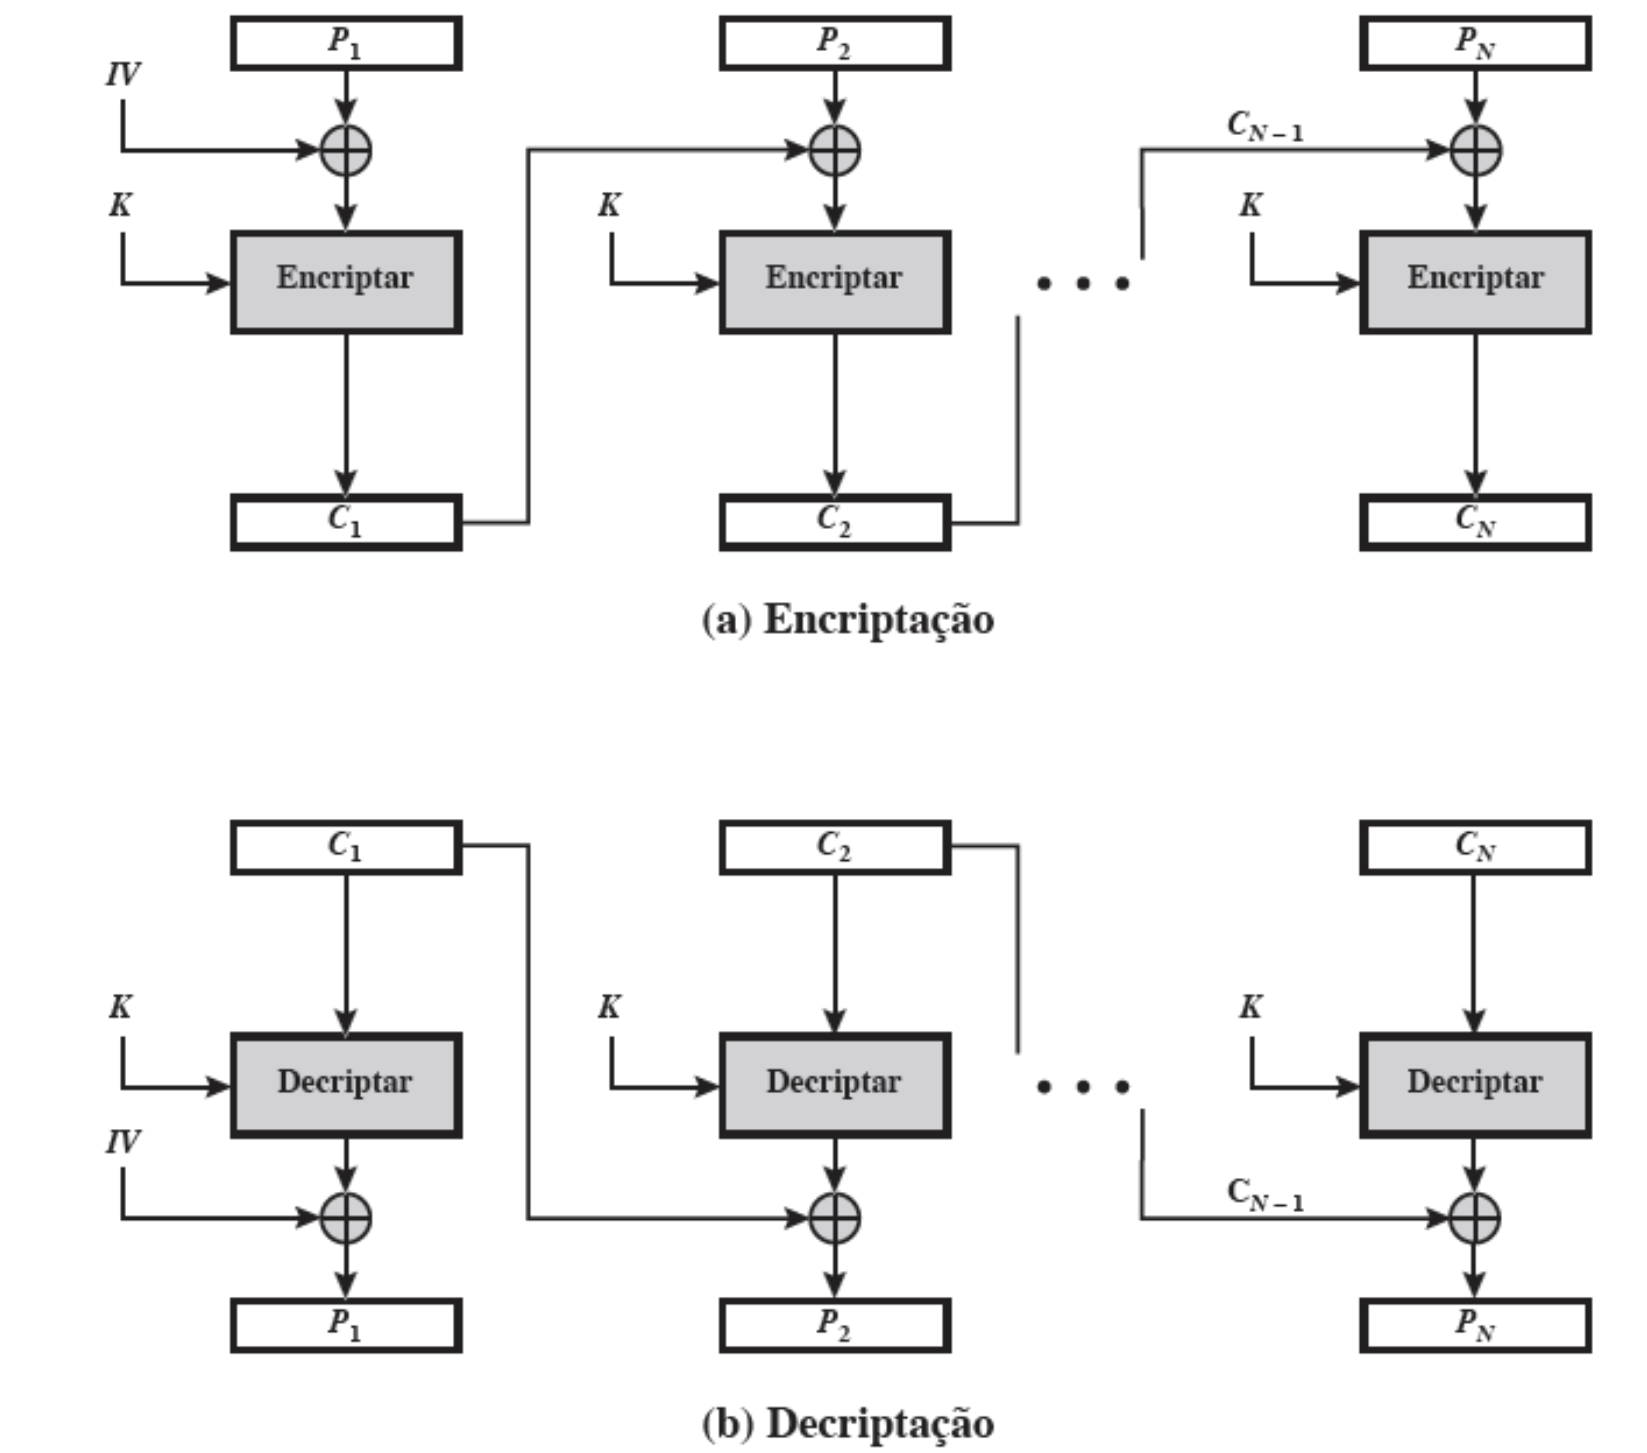

In [144]:
class CBC(ModoOperacao):
    def set_vetor_inicial(self, vetor_inicial):
        self.vetor_inicial = vetor_inicial

    def set_tamanho_bloco(self, tamanho_bloco):
        self.tamanho_bloco = tamanho_bloco

    def gerar_vetor_inicial(self):
        return numerico_para_binario(random.getrandbits(self.tamanho_bloco)).zfill(self.tamanho_bloco)

    def encriptar(self, M: str) -> str:
        logger.info(f'Encriptando mensagem {M}')
        # Inicializando a mensagem criptografada
        C = ''
        # Setando o vetor inicial
        C_anterior = self.vetor_inicial
        logger.info(f'O vetor de inicialização é {C_anterior}')
        # Para cada bloco da mensagem
        for i in range(0, len(M), self.tamanho_bloco):
            logger.info(f'Encriptando bloco {M[i:i+self.tamanho_bloco]}')
            M_atual_xor = xor(M[i:i+self.tamanho_bloco], C_anterior)
            logger.info(f'O XOR entre o bloco atual da mensagem e o bloco cifrado anterior é {M_atual_xor}')
            # Encripta o XOR entre o bloco atual da mensagem e o bloco cifrado anterior
            C_atual = self.cifra.Enc(M_atual_xor)
            logger.info(f'O bloco cifrado atual é {C_atual}')
            # Concatena o bloco cifrado atual à mensagem criptografada
            C += C_atual
            # O bloco cifrado atual se torna o bloco anterior da próxima iteração
            C_anterior = C_atual
            logger.info('----------------------------------------------')
        logger.info(f'A mensagem criptografada é: {C}')
        return C

    def decriptar(self, C: str) -> str:
        logger.info(f'Decriptando mensagem {C}')
        # Inicializando a mensagem decriptografada
        M = ''
        # Setando o vetor inicial
        C_anterior = self.vetor_inicial
        logger.info(f'O vetor de inicialização é {C_anterior}')
        # Para cada bloco da mensagem
        for i in range(0, len(C), self.tamanho_bloco):
            logger.info(f'Decriptando bloco {C[i:i+self.tamanho_bloco]}')
            # Decripta o bloco cifrado atual
            M_atual = self.cifra.Dec(C[i:i+self.tamanho_bloco])
            logger.info(f'O bloco decriptografado atual é {M_atual}')
            # Concatena o XOR do bloco decriptografado atual com o bloco cifrado anterior à mensagem decriptografada
            M_atual_xor = xor(C_anterior, M_atual)
            logger.info(f'O XOR entre o bloco cifrado atual e o bloco decriptografado anterior é {M_atual_xor}')
            M+=M_atual_xor
            # O bloco cifrado atual se torna o bloco anterior da próxima iteração
            C_anterior = C[i:i+self.tamanho_bloco]
            logger.info('----------------------------------------------')
        logger.info(f'A mensagem decriptografada é: {M}')
        return M

In [145]:
logger.info('------------------------------------------')
logger.info('Execução do modo de operação CBC com algoritmo SDES')
sdes = SDES()
sdes.set_key('1010000010')
logger.info('')
cbc = CBC(sdes)
cbc.set_tamanho_bloco(8)
cbc.set_vetor_inicial('01010101')
M = '11010111011011001011101011110000'
C = cbc.encriptar(M)
logger.info('')
M_ = cbc.decriptar(C)
assert M == M_
logger.info('------------------------------------------')

INFO:root:------------------------------------------
INFO:root:Execução do modo de operação CBC com algoritmo SDES
INFO:root:Gerando subchaves a partir da chave 1010000010
INFO:root:	Após a realização da operação P10, a sequência resultante é 1000001100
INFO:root:	Após a realização da operação S1, a sequência resultante é 0000111000
INFO:root:	Após a realização da operação P8, a subchave K1 resultante é 10100100
INFO:root:	Após a realização da operação S2, a sequência resultante é 0010000011
INFO:root:	Após a realização da operação P8, a subchave K2 resultante é 01000011
INFO:root:As subchaves geradas são OrderedDict([('K1', '10100100'), ('K2', '01000011')])
INFO:root:
INFO:root:Encriptando mensagem 11010111011011001011101011110000
INFO:root:O vetor de inicialização é 01010101
INFO:root:Encriptando bloco 11010111
INFO:root:O XOR entre o bloco atual da mensagem e o bloco cifrado anterior é 10000010
INFO:root:Encriptando a mensagem 10000010
INFO:root:	Após a realização da operação IP, a 

In [146]:
print(f'A mensagem criptografada é {C}')

A mensagem criptografada é 00001011101010011001101101101010


# Conclusão

O SDES e modos de operação EBC e CBC foram implementados e testados conforme mensagens, chaves e vetor de inicialização de informados. Evidenciada a didaticidade do trabalho, haja vista que SDES é versão simplificada do DES, não mais apropriado à criptografia em sistemas produtivos, observou-se que a arquitetura modular pode ser estendida a cifras mais avançadas. DES não foi objeto de implementação, porém modulos implementados poderiam ter sido utilizados tanto para sua construção quanto a do 3DES.

# Referências

GOOGLE. Gemini via Google Colab [ferramenta de inteligência artificial]. Mountain View, CA: Google, 2024. Disponível em: https://colab.research.google.com/. Acesso em: 21 abr. 2025.

OPENAI. ChatGPT (versão GPT-4) [ferramenta de inteligência artificial]. São Francisco, CA: OpenAI, 2023. Disponível em: https://chat.openai.com/. Acesso em: 21 abr. 2025.

TERENCELI. Simplified Data Encryption Standard (SDES). 2014. Disponível em: https://terenceli.github.io/assets/file/mimaxue/SDES.pdf. Acesso em: 14 maio 2025.